First, import needed modules

In [154]:
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.speedups
from shapely import wkt
from shapely.ops import unary_union

Initalize variables

In [155]:
shapely.speedups.enable()
path = os.getcwd()
print(path)

/Users/jan/Dropbox/UP_EPQM/2222/MA/powerlinemonsters


Load shapefile with municipality and state boundaries and plot it for inspection

<AxesSubplot:>

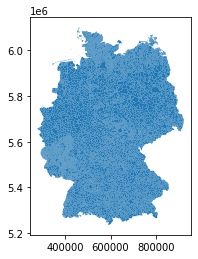

In [156]:
municipalities = gpd.read_file(f'{path}/data/geodata/VG250_GEM.shp')
mun = pd.DataFrame(municipalities).drop(columns='geometry')
states = gpd.read_file(f'{path}/data/geodata/VG250_LAN.shp')
municipalities.plot()

Inspect the dataframe: GEN has the municipalities' names, geometry are the polygons.


In [157]:
municipalities.head()
mun_pd = pd.DataFrame(municipalities.drop(columns='geometry'))

Drop polygons which represent waterbodies and gemeindefreie Gebiete (mostly forests), here # of Inhabitats (EWZ) == 0

<AxesSubplot:>

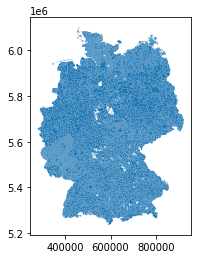

In [158]:
municipalities = municipalities[municipalities['GF'] == 4] 
municipalities = municipalities[municipalities["BEZ"] != 'Gemeindefreies Gebiet']
municipalities.plot()

The data use the European Terrestrial Reference System 1989 as coordinate reference system (CRS), units are metres

In [159]:
municipalities.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Load shapefiles with power lines, start and endpoints

In [160]:
powerlines = gpd.read_file(f'{path}/data/geodata/powerlines.shp')
startpoints = gpd.read_file(f'{path}/data/geodata/startpoints.shp')
endpoints = gpd.read_file(f'{path}/data/geodata/endpoints.shp')
powerlines.head()

,#BBPlG,Start,End,New,Retro,Short,geometry
0,1,Emden-Borssum,"52.20189, 7.03448",1.0,NaN,NaN,"LINESTRING (381802.135 5912655.617, 365771.558..."
1,1,"52.20189, 7.03448",Osterath,1.0,NaN,NaN,"LINESTRING (365771.558 5785222.130, 334024.420..."
2,2,Osterath,Philippsburg,1.0,NaN,NaN,"LINESTRING (334024.420 5682438.683, 460302.514..."
3,3,Brunsbüttel,Aub,1.0,NaN,NaN,"LINESTRING (509169.440 5972099.313, 577051.542..."
4,3,Aub,Großgartach,1.0,NaN,NaN,"LINESTRING (577051.542 5489422.549, 509180.155..."


Plot for inspection

<AxesSubplot:>

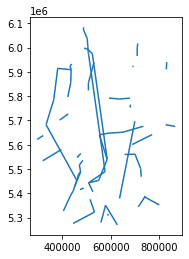

In [161]:
powerlines.plot()

Combine municipalities and powerlines in a plot

In [162]:
powerlines.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
powerlines.plot(ax=ax, color='red', lw=2, zorder=3)
plt.title('BBPlG 2013 projects \n All projects (new and retrofit)', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_all_projects.png')
plt.close()

Filter out Retrofitting projects

In [163]:
powerlines = powerlines[powerlines['New'] == 1]
startpoints = startpoints[startpoints['New'] == 1]
endpoints = endpoints[endpoints['New'] == 1]
powerlines.head()

,#BBPlG,Start,End,New,Retro,Short,geometry
0,1,Emden-Borssum,"52.20189, 7.03448",1.0,NaN,NaN,"LINESTRING (381802.135 5912655.617, 365771.558..."
1,1,"52.20189, 7.03448",Osterath,1.0,NaN,NaN,"LINESTRING (365771.558 5785222.130, 334024.420..."
2,2,Osterath,Philippsburg,1.0,NaN,NaN,"LINESTRING (334024.420 5682438.683, 460302.514..."
3,3,Brunsbüttel,Aub,1.0,NaN,NaN,"LINESTRING (509169.440 5972099.313, 577051.542..."
4,3,Aub,Großgartach,1.0,NaN,NaN,"LINESTRING (577051.542 5489422.549, 509180.155..."


Filter out short lines and intermediate start- and endpoints

<AxesSubplot:>

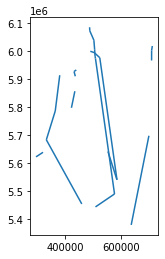

In [164]:
powerlines = powerlines[powerlines['Short'].isna()]
startpoints = startpoints[startpoints['Int_start'].isna()]
endpoints = endpoints[endpoints['Int_end'].isna()]
powerlines.plot()

Export new powerline shapefile

In [165]:
powerlines.to_file(f'{path}/data/geodata/new_powerlines.shp')

Combine municipalities and NEW powerlines in a plot

In [166]:
powerlines.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='black', lw = 0.1, zorder=2)
powerlines.plot(ax=ax, color='red', lw=2, zorder=3)

startpoints.plot(ax=ax, color='red', lw=1, zorder=4)
endpoints.plot(ax=ax, color='red', lw=0.5, zorder=5)
'''
for x, y, label in zip(startpoints.geometry.x, startpoints.geometry.y, startpoints.Start):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=5)
for x, y, label in zip(endpoints.geometry.x, endpoints.geometry.y, endpoints.End):
    ax.annotate(label, xy=(x, y), xytext=(-3, 3), textcoords="offset points", fontsize=5)
'''
plt.title('BBPlG 2013 projects \n New projects', fontsize=20)
plt.savefig(f'{path}/figures/BBPLG2013_new_projects.png')
plt.close()

Create buffers around the straight lines to create treatment indicator for different corridor widths

In [167]:
for buffer in (5, 10, 15, 25, 50):
    try:
        powerlines.insert(loc=len(powerlines.columns), column=f'geometry_{buffer*2}', value=0) #buffer is added on both sides -> x2 to simplify
    except Exception:
        pass
    powerlines[f'geometry_{buffer*2}'] = powerlines['geometry'].buffer(buffer*1000)
powerlines.rename(columns = {'geometry':'geometry_0'}, inplace = True)
powerlines.head()

,#BBPlG,Start,End,New,Retro,Short,geometry_0,geometry_10,geometry_20,geometry_30,geometry_50,geometry_100
0,1,Emden-Borssum,"52.20189, 7.03448",1.0,NaN,NaN,"LINESTRING (381802.135 5912655.617, 365771.558...","POLYGON ((370732.460 5784598.070, 370647.403 5...","POLYGON ((375693.362 5783974.011, 375523.248 5...","POLYGON ((380654.264 5783349.951, 380399.094 5...","POLYGON ((390576.068 5782101.831, 390150.785 5...","POLYGON ((415380.578 5778981.532, 414530.012 5..."
1,1,"52.20189, 7.03448",Osterath,1.0,NaN,NaN,"LINESTRING (365771.558 5785222.130, 334024.420...","POLYGON ((338801.725 5680963.097, 338634.089 5...","POLYGON ((343579.031 5679487.512, 343243.757 5...","POLYGON ((348356.336 5678011.926, 347853.426 5...","POLYGON ((357910.947 5675060.755, 357072.763 5...","POLYGON ((381797.474 5667682.827, 380121.107 5..."
2,2,Osterath,Philippsburg,1.0,NaN,NaN,"LINESTRING (334024.420 5682438.683, 460302.514...","POLYGON ((464678.801 5456336.019, 464894.761 5...","POLYGON ((469055.088 5458754.306, 469487.009 5...","POLYGON ((473431.375 5461172.593, 474079.257 5...","POLYGON ((482183.949 5466009.166, 483263.752 5...","POLYGON ((504065.385 5478100.600, 506224.990 5..."
3,3,Brunsbüttel,Aub,1.0,NaN,NaN,"LINESTRING (509169.440 5972099.313, 577051.542...","POLYGON ((582002.817 5490118.880, 582047.228 5...","POLYGON ((586954.092 5490815.212, 587042.913 5...","POLYGON ((591905.367 5491511.543, 592038.599 5...","POLYGON ((601807.917 5492904.205, 602029.970 5...","POLYGON ((626564.291 5496385.862, 627008.397 5..."
4,3,Aub,Großgartach,1.0,NaN,NaN,"LINESTRING (577051.542 5489422.549, 509180.155...","POLYGON ((511990.074 5439173.425, 511571.170 5...","POLYGON ((514799.992 5435037.683, 513962.184 5...","POLYGON ((517609.910 5430901.941, 516353.198 5...","POLYGON ((523229.746 5422630.458, 521135.226 5...","POLYGON ((537279.337 5401951.749, 533090.296 5..."


Now generate treatment indicators for all buffer sizes

In [168]:
for buffer in (0, 5, 10, 15, 25, 50):
    try:
        municipalities.insert(loc=len(municipalities.columns), column=f'treated_{buffer*2}', value=0)
    except Exception:
        pass
    for i in range(len(municipalities)):
        # this sets treated_x = True, if powerline intersects a municipality
        municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = any(powerlines[f'geometry_{buffer*2}'].intersects(municipalities['geometry'].values[i]))
municipalities.head()

,ADE,GF,BSG,RS,AGS,SDV_RS,GEN,BEZ,IBZ,BEM,...,WSK,EWZ,DEBKG_ID,geometry,treated_0,treated_10,treated_20,treated_30,treated_50,treated_100
132,6,4,1,084375006105,08437105,084375006105,Sigmaringendorf,Gemeinde,64,gemeinschaftsangehörig,...,2009-01-01,3579,DEBKGDL20000E1A1,"MULTIPOLYGON (((519739.281 5326044.596, 519836...",False,False,False,False,False,False
133,6,4,1,084355004010,08435010,084355004010,Daisendorf,Gemeinde,64,gemeinschaftsangehörig,...,2009-01-01,1567,DEBKGDL20000DXY9,"POLYGON ((520024.250 5285171.532, 520282.129 5...",False,False,False,False,False,False
134,6,4,1,084265001036,08426036,084265001036,Dürnau,Gemeinde,64,gemeinschaftsangehörig,...,2009-01-01,416,DEBKGDL20000E2FC,"POLYGON ((539650.245 5323326.647, 540371.109 5...",False,False,False,False,False,False
135,6,4,1,084365003079,08436079,084365003079,Waldburg,Gemeinde,64,gemeinschaftsangehörig,...,2009-01-01,3097,DEBKGDL20000DWDG,"POLYGON ((555188.210 5292814.174, 555101.559 5...",False,False,False,False,False,False
136,6,4,1,084365001053,08436053,084365001053,Königseggwald,Gemeinde,64,gemeinschaftsangehörig,...,2009-01-01,663,DEBKGDL20000DYBW,"MULTIPOLYGON (((529968.394 5308622.822, 530000...",False,False,False,False,False,False


In [169]:
print(municipalities['treated_0'].describe())

count     11159
unique        2
top       False
freq      10664
Name: treated_0, dtype: object


Set treatment = False if municipality is a start- or endpoint

In [170]:
for buffer in (0, 5, 10, 15, 25, 50):
    for i in range(len(municipalities)):
        # this sets treated_x = False if municipality contains a start- or endpoint
        if any(startpoints['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = False
        elif any(endpoints['geometry'].within(municipalities['geometry'].values[i])):
            municipalities.loc[municipalities.index[i], f'treated_{buffer*2}'] = False

In [171]:
print(municipalities['treated_0'].describe())

count     11159
unique        2
top       False
freq      10692
Name: treated_0, dtype: object


Export municipality shapefile

In [172]:
municipalities.to_file(f'{path}/data/geodata/municipalities.shp')

/var/folders/wm/mtrphj0s0msgrmyshf3hgk740000gn/T/ipykernel_25664/2899806917.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  municipalities.to_file(f'{path}/data/geodata/municipalities.shp')


Create single treatment indicator 

In [173]:
municipalities['treatment'] = np.where(municipalities['treated_100'] == True, 100, 'None')
municipalities['treatment'] = np.where(municipalities['treated_50'] == True, 50, municipalities['treatment'])
municipalities['treatment'] = np.where(municipalities['treated_30'] == True, 30, municipalities['treatment'])
municipalities['treatment'] = np.where(municipalities['treated_20'] == True, 20, municipalities['treatment'])
municipalities['treatment'] = np.where(municipalities['treated_10'] == True, 10, municipalities['treatment'])
municipalities['treatment'] = np.where(municipalities['treated_0'] == True, 0, municipalities['treatment'])

Export treatment dataset from municipalities dataframe

In [174]:
treatment = pd.DataFrame(municipalities)
treatment = treatment.reindex(columns=['AGS', 'GEN', 'treatment', 'treated_0', 'treated_10', 'treated_20', 'treated_30', 'treated_50', 'treated_100'])
treatment = treatment.set_index('AGS')
treatment = treatment.replace({True:1, False:0})
treatment.to_csv(f'{path}/data/treatment.csv', encoding = 'utf-8-sig')
treatment.head()

,GEN,treatment,treated_0,treated_10,treated_20,treated_30,treated_50,treated_100
AGS,,,,,,,,
08437105,Sigmaringendorf,None,0,0,0,0,0,0
08435010,Daisendorf,None,0,0,0,0,0,0
08426036,Dürnau,None,0,0,0,0,0,0
08436079,Waldburg,None,0,0,0,0,0,0
08436053,Königseggwald,None,0,0,0,0,0,0


In [175]:
print

<function print>

Plot municipalities that intersect with a powerline

In [176]:
municipalities_intersected0 = municipalities[municipalities['treated_0'] == True] #drops all untreated munipalities
municipalities_intersected10 = municipalities[municipalities['treated_10'] == True]
municipalities_intersected20 = municipalities[municipalities['treated_20'] == True]
municipalities_intersected30 = municipalities[municipalities['treated_30'] == True]
municipalities_intersected50 = municipalities[municipalities['treated_50'] == True] 
municipalities_intersected100 = municipalities[municipalities['treated_100'] == True]

In [177]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
municipalities_intersected100.plot(ax=ax, color='#ffed7f', edgecolor='darkorange', lw=0.01, zorder=3, label='100 km')
municipalities_intersected50.plot(ax=ax, color='#FFDB00', edgecolor='darkorange', lw=0.01, zorder=4, label='50 km')
municipalities_intersected30.plot(ax=ax, color='#F8BA09', edgecolor='darkorange', lw=0.01, zorder=5, label='30 km')
municipalities_intersected20.plot(ax=ax, color='#F19A11', edgecolor='darkorange', lw=0.01, zorder=6, label='20 km')
municipalities_intersected10.plot(ax=ax, color='#E9791A', edgecolor='darkorange', lw=0.01, zorder=7, label='10 km')
municipalities_intersected0.plot(ax=ax, color='#E25822', edgecolor='darkorange', lw=0.01, zorder=8, label='0 km')
#municipalities.plot(column='treatment', ax=ax, edgecolor='darkorange', lw=0.01, zorder=3, legend=True, cmap='viridis')
powerlines = powerlines.set_geometry('geometry_0')
powerlines.plot(ax=ax, color='red', lw=2, zorder=9)
plt.title('Municipalities affected by BBPlG 2013 projects', fontsize=20)
ax.annotate('Source: Rajasthan Datastore, 2019',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='black')
plt.savefig(f'{path}/figures/BBPLG2013_treatments.png')
plt.close()

Plot municipalities with data for postal ballot

In [178]:
btw = pd.read_csv(f'{path}/data/btw.csv', encoding = 'utf-8-sig', converters={'AGS': str})
btw_postal = btw[btw['Vote type'] == 'postal']
btw_postal_ags = btw_postal['AGS']
btw_postal_plot = pd.merge(btw_postal_ags, municipalities, on='AGS')
btw_postal_plot = btw_postal_plot.set_geometry('geometry')

btw_other = btw[btw['Vote type'] == 'other']
btw_other_ags = btw_postal['AGS']
btw_other_plot = pd.merge(btw_other_ags, municipalities, on='AGS')
btw_other_plot = btw_other_plot.set_geometry('geometry')

In [179]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
ax.set_aspect('equal')
ax.set_axis_off()
municipalities.plot(ax=ax, color='lightblue', edgecolor='blue', lw=0.01, zorder=1)
states.boundary.plot(ax=ax, color='darkblue', lw = 0.1, zorder=2)
btw_postal_plot.plot(ax=ax, color='#E9791A', edgecolor='darkorange', lw=0.01, zorder=3)
#btw_other_plot.plot(ax=ax, color='green', edgecolor='darkorange', lw=0.01, zorder=4)
powerlines = powerlines.set_geometry('geometry_0')
powerlines.plot(ax=ax, color='red', lw=2, zorder=5)
plt.title('Municipalities affected by BBPlG 2013 projects \n with postal ballot data', fontsize=20)
ax.annotate('Source: Rajasthan Datastore, 2019',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='black')
plt.savefig(f'{path}/figures/mun_postal.png')
plt.close()